<h1 style="font-size:300#">Iris classification with Nearest Neigbors</h1>

BSHT Michielsen MSc

Updated by Martin Tomov, Feb 2024

This notebook demonstrates how to use the [sklearn Nearest Neigbours classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) algorithm to classify iris flowers based on simple mearements of their petals and sepals. The iris is a flower with a particular appearance because it has different parts that are shaped significantly different among the three typical species, see the image below. Therefore, it is relatively easy for a human to identify which species of iris we are dealing with based on the shape of those parts, and it is also relatively easy to let a machine classify them using the same metrics. Note that is a classification problem, so we use the `classifier` variety of nearest neighbors. A `regression` variety exists as well for other problems.

<img src="https://machinelearninghd.com/wp-content/uploads/2021/03/iris-dataset.png" />

First, we show the versions of the required libraries (that is always wise to do in case you have to report problems running the notebooks!).

In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
import seaborn as sns

print("scikit-learn version:", sk.__version__)          # 1.1.1
print("numpy version:", np.__version__)                 # 1.22.4
print("pandas version:", pd.__version__)                # 1.4.2
print("seaborn version:", sns.__version__)              # 0.11.2

scikit-learn version: 1.3.0
numpy version: 1.23.2
pandas version: 2.0.3
seaborn version: 0.13.2


# Data provisioning
In real life your data provisioning is likely to include more steps about data sourcing and data quality, however for demo purposes in this notebook we limit it to merely loading the data using the [pandas read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function, without any concern over quantity nor quality. The data has 150 observations in 5 columns namely 4 features and 1 target variable.

In [2]:
columns = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width", "Species"]
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", names=columns)
print(df.shape)

(150, 5)


# Sample the data
To get an impression of the data, here we take a sample of 10 observations from the set and have a look at the features. The idea here is that a certain combination of values for the features is more likely to mean a certain species. For example `iris-setosa` seems to have a relatively small `Petal Width` and `iris-versicolor` has a relatively high `Sepal Length`. Knowing this, one could, given the lengths and widths for sepal and petal make an educated guess of the species by looking at how close its values are to already existing observations. This is the idea of Nearest Neighbors, it looks for "how close" a new observation is to previous known observations. In the second part we look at how many observations there are for each of the classes in the target variable. Because this dataset is very balanced there are exacly 50 observations for each of the 3 classes.

In [3]:
df.sample(10)

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
31,5.4,3.4,1.5,0.4,Iris-setosa
60,5.0,2.0,3.5,1.0,Iris-versicolor
132,6.4,2.8,5.6,2.2,Iris-virginica
55,5.7,2.8,4.5,1.3,Iris-versicolor
2,4.7,3.2,1.3,0.2,Iris-setosa
94,5.6,2.7,4.2,1.3,Iris-versicolor
110,6.5,3.2,5.1,2.0,Iris-virginica
126,6.2,2.8,4.8,1.8,Iris-virginica
124,6.7,3.3,5.7,2.1,Iris-virginica
80,5.5,2.4,3.8,1.1,Iris-versicolor


In [4]:
groupinfo = df.groupby(["Species"])["Species"].count()
print(groupinfo)

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64


# Preprocessing
The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the species of an iris flower. 

### Target variable
The first thing to do here would be making sure that we have a numeric target variable. Algorithms work only with numbers and therefore can only give a number as a result. Let's make a new column `Species ID` that is a number for the `Species`. It does not really matter which numbers we pick, so let's do 1, 2 and 3, for lack of inspiration. 🧐

In [5]:
df["Species ID"] = df["Species"].map({"Iris-setosa": 1, "Iris-versicolor": 2, "Iris-virginica": 3})
df.sample(10)

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species,Species ID
146,6.3,2.5,5.0,1.9,Iris-virginica,3
99,5.7,2.8,4.1,1.3,Iris-versicolor,2
5,5.4,3.9,1.7,0.4,Iris-setosa,1
95,5.7,3.0,4.2,1.2,Iris-versicolor,2
19,5.1,3.8,1.5,0.3,Iris-setosa,1
61,5.9,3.0,4.2,1.5,Iris-versicolor,2
79,5.7,2.6,3.5,1.0,Iris-versicolor,2
33,5.5,4.2,1.4,0.2,Iris-setosa,1
12,4.8,3.0,1.4,0.1,Iris-setosa,1
54,6.5,2.8,4.6,1.5,Iris-versicolor,2


### Feature selection
Perhaps the most important step is 'feature selection', which is the activity of deciding which of the available features to use in order to predict the target variable. A common mistake is to just take all features "because knowing more, implies a higher chance of guessing correct", which is not true. Sometimes some features do not help at all, and some even produce noise in the algorithm. It is therefore important to pick only those features that can together explain the variance in the target variable the best. For a classification algorithm that would mean that any feature that has distinguishable values per class would be good. A way to look for this is by creating a [pandas box plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html).

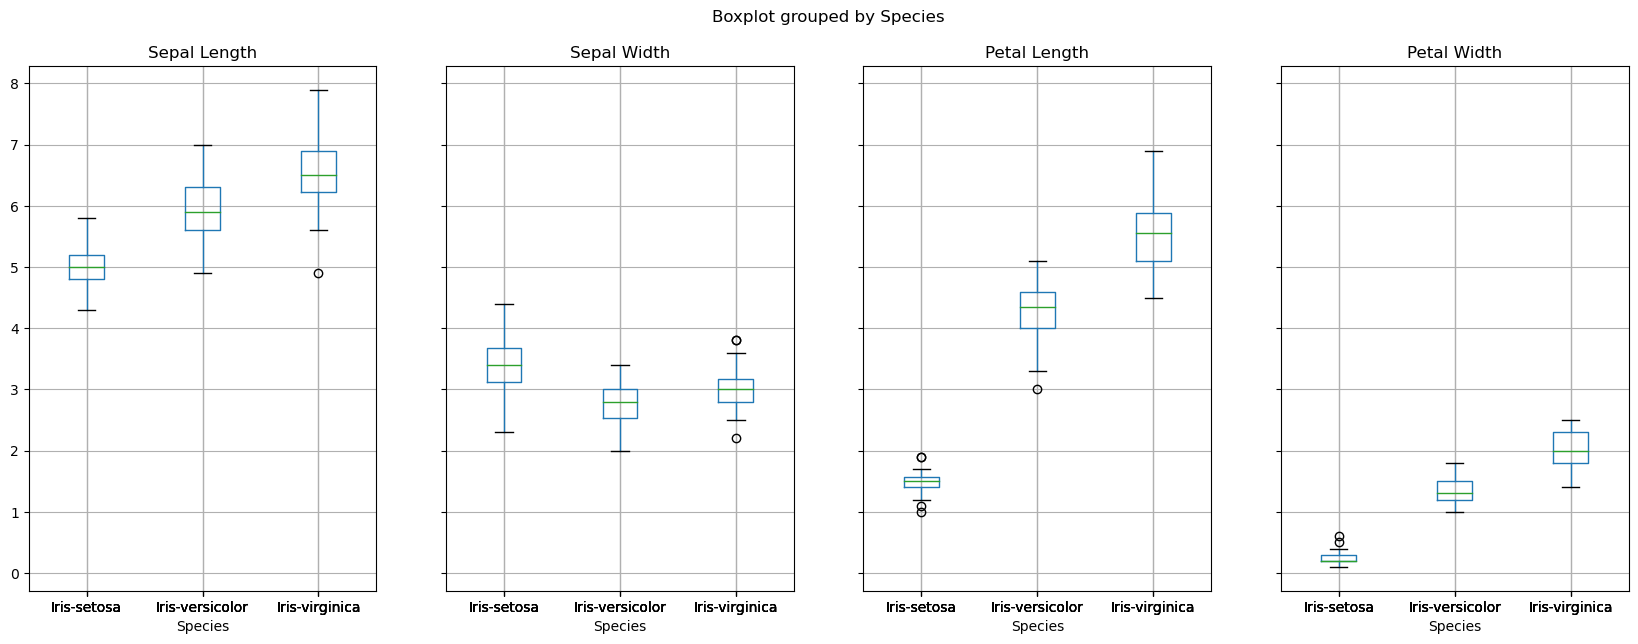

In [6]:
features = columns[:-1]
plot = df.boxplot(column=features, by="Species", figsize=(20,7), layout=(1,len(features)))

The idea here is that if the boxes are vertically close to each other, that feature would be less good because the values of that feature are close to each other and therefore hard to distinguish. A feature in which the boxes are vertically far away from each other would be a good feature. Now, in this dataset any feature is still a fair choice, but for example `Petal Length`, having boxes far away from each other, would be a better choice than `Sepal Width` where the boxes are closer to each other. Also `Petal Width` seems to be a fair choice. The selected features we put into a variable named `X` and the target variable we put in a variable named `y`.

In [7]:
X = df[["Petal Length", "Petal Width"]]
y = df["Species ID"]

### Splitting train/test
Before we can train the model, we need to take a little part of our data that we use for testing purposes. The idea here is that the model trains with, for example 80% of the data that we have, and we use the other 20% to ask it to predict the target variable for. Now, because we know the true target variable of that 20% we can compare the results that the model gives us with the ground truth and come up with how well the model performs. Let's make a train/test split now.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations.")
print("The train set now has", len(X_train), "observations.")
print("The trest set now has", len(X_test), "observations.")

There are in total 150 observations.
The train set now has 120 observations.
The trest set now has 30 observations.


### Scaling
The Nearest Neigbors algorithm uses the concept of "being near" as to decide which species an unknown iris would be. This "being near" is calculated using [Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance), which is an absolute measurement between two values of the same feature, but not among features. It is therefore needed to scale all the features such that they use the same unit of measurement. Here is an example that demonstrates why:
> Given the numbers 6 and 8, the Euclidian distance would be 2. Given the numbers 95 and 100 the Euclidian distance would be 5. However, 95 and 100 are in fact closer to eachother (95%) than 6 and 8 are (75%).

Therefore it is important that among features the same unit is used. A common unit to use is [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation), and sklearn provides the `StandardScaler` to transform all values into that same unit. After that we can make a scatter plot to see the actual distances between the iris flowers. Note that the distance is in standard deviations (σ).

/var/folders/bn/xzwp15h96jg7vf7qxvsqkry80000gn/T/ipykernel_35989/2942353307.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  ax.legend(ax.legend_.legendHandles, df["Species"].unique(), title="Species")


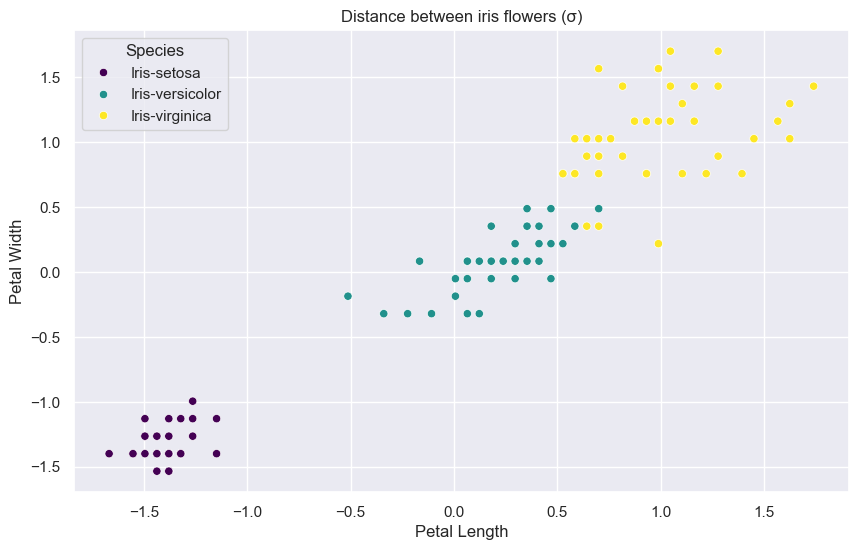

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

sns.set(rc={"figure.figsize":(10, 6)})
ax = sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train, palette="viridis")
ax.set(xlabel=X.columns[0], ylabel=X.columns[1], title="Distance between iris flowers (σ)")
ax.legend(ax.legend_.legendHandles, df["Species"].unique(), title="Species")


# Modelling
In this step we are going to use the train set only to fit the model, in this case Nearest Neigbors for classification named [kNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). And then we use the test set to calculate the model's accuracy, in other words how well it performs. Accuracy is a fraction where any value closer to 1 is considered better, and 1 itself (100% accurate) is usually impossible.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, y_test)
print("Accuracy:", acc)

Accuracy: 0.9333333333333333


# Evaluation
Now let us see if we can shed some light on the results. What we can do here is print a classification report. This shows for every one of the classes how well the model performed.

In [13]:
from sklearn.metrics import classification_report
report = classification_report(y_test, pred, target_names=df["Species"].unique())
print(report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        14
Iris-versicolor       0.88      0.88      0.88         8
 Iris-virginica       0.88      0.88      0.88         8

       accuracy                           0.93        30
      macro avg       0.92      0.92      0.92        30
   weighted avg       0.93      0.93      0.93        30



# Inference Example

Now that the model is trained for predicting iris species based on a given petal length and petal width, it can now be used to inference a class for a new observation. This means that for any given combination of petal length and petal width it can give a probability of how likely that combination indicates the classes that the model knows. Feel free to change the values for `petal_length` and `petal_width` below to get another prediction. Note that the values provided are in cm, but the model was trained on standard deviations. Therefore the same scaler is used again to transform the given values into standard deviations before feeding the values to the model.

In [14]:
petal_length = 5.5
petal_width = 1.5

X_inference = pd.DataFrame([{"Petal Length": petal_length, "Petal Width": petal_width}])
X_inference = scaler.transform(X_inference)

prediction = model.predict_proba(X_inference)
result = pd.DataFrame()
result["Class"] = df["Species"].unique()
result["Probability"] = prediction[0]
result

,Class,Probability
0,Iris-setosa,0.0
1,Iris-versicolor,0.4
2,Iris-virginica,0.6


## Feature selection - Task 1
In the section about feature selection we selected `Petal Length` and `Petal Width` as our two features to base the modelling on. Pick any other two features and compare the results. Did it work beter? If yes, why, if no, why? What happens if you select 3 features?

In [15]:
# Feature selection - 2 new features
features = ["Sepal Length", "Sepal Width"]

# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardizing the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Building and training the KNeighborsClassifier model
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

# And finally evaluating the model's performance
from sklearn.metrics import accuracy_score
score = accuracy_score(pred, y_test)
print("Accuracy with new features:", score)

Accuracy with new features: 1.0


In [16]:
# Feature selection - all 4 features
features = ["Petal Length", "Petal Width", "Sepal Length", "Sepal Width"] 

# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardizing the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Building and training the KNeighborsClassifier model
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

# And finally evaluating the model's performance
from sklearn.metrics import accuracy_score
score = accuracy_score(pred, y_test)
print("Accuracy with new features:", score)

Accuracy with new features: 0.9333333333333333


> ## Feature selection - Results comparison

I selected the septal length and width to test them out. The output shows an accuracy of `0.9333333333333333` or about `93.33%` with `Sepal Length` and `Sepal Width` as features. 

The previous result of the model accuracy before setting `Sepal Length` and `Sepal Width` as features the accuracy was approximately `96.67%`. Since this is higher than the `93.33%` accuracy obtained, we can conclude that `Petal Length` and `Petal Width` provided a better basis for the model to classify the iris species. This could be due to these features having a stronger connection with the species classification in the `Iris dataset`, which leads to a more accurate model. The septals of the flowers are more similar than their petals so its harder to recognise the differences this way.

When I added a `third feature` I got even better and consistent results which is expected, and if you use all `4 features` you get the most consistent results with regular accuracy score of <b>1.0 = 100%</b>.

## Different results - Task 2
If you re-run this notebook a few times, without changing anything, you sometimes get slightly different results. Explain why you believe this is. Compare your answer with a fellow student. Did they have the same opinion? If not, explain the difference. 

In [17]:
from sklearn.metrics import classification_report
# Generating a classification report with features = ["Sepal Length", "Sepal Width"]
report = classification_report(y_test, pred, target_names=df["Species"].unique())
print(report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       0.86      0.86      0.86         7
 Iris-virginica       0.92      0.92      0.92        12

       accuracy                           0.93        30
      macro avg       0.92      0.92      0.92        30
   weighted avg       0.93      0.93      0.93        30



In [18]:
from sklearn.metrics import classification_report
# Generating a classification report with features = ["Petal Length", "Petal Width", "Sepal Length", "Sepal Width"] 
report = classification_report(y_test, pred, target_names=df["Species"].unique())
print(report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       0.86      0.86      0.86         7
 Iris-virginica       0.92      0.92      0.92        12

       accuracy                           0.93        30
      macro avg       0.92      0.92      0.92        30
   weighted avg       0.93      0.93      0.93        30



> ## Reason for Different Results

1. The k-NN algorithm shuffles the data during training and this can lead to different results each time.
2. It's likely because the `train_test_split` function randomly partitions the dataset each time it's called unless a `random_state` is set. 

### Hyperparameter n_neighbors
The constructor of the kNeighborsClassifier has an optional hyperparameter named `n_neighbors`, which by default is `5`. Try providing a value of `2` for this parameter and see if this makes any difference. Then provide a value of `85` for this parameter and note any differences. Which of those 3 values [`5`, `2`, `85`] would you say gives the best results and why?

In [21]:
# For n_neighbors = 2
model_n2 = KNeighborsClassifier(n_neighbors=2)
model_n2.fit(X_train, y_train)
pred_n2 = model_n2.predict(X_test)
score_n2 = accuracy_score(pred_n2, y_test)

# For n_neighbors = 85
model_n85 = KNeighborsClassifier(n_neighbors=85)
model_n85.fit(X_train, y_train)
pred_n85 = model_n85.predict(X_test)
score_n85 = accuracy_score(pred_n85, y_test)

# Print the accuracy for each model
print("Accuracy (n_neighbors=2):", score_n2)
print("Accuracy (n_neighbors=5):", score)  # Default n_neighbors=5
print("Accuracy (n_neighbors=85):", score_n85)

Accuracy (n_neighbors=2): 0.9333333333333333
Accuracy (n_neighbors=5): 0.9333333333333333
Accuracy (n_neighbors=85): 0.23333333333333334


> ## Hyperparameter n_neighbors Results Analysis:
A lower n_neighbors value means that the model is considering a smaller number of nearest points, which can make it sensitive to noise but also potentially more adaptable to local variations. A very high n_neighbors value (like 85) can make the model too generalized, as it's considering a very large neighborhood for making predictions, which might dilute the influence of the closest and most relevant points. In this case, either 2 or 5 gives the best results because 85 leads to over-generalization and a loss of accuracy.

Among the three values `5`, `2`, and `85` for the `n_neighbors` hyperparameter, the choice that gives the best results is `5`. 